# Handwritten OCR Playground

Interactive notebook for testing and debugging the handwritten notes OCR pipeline.

## 1. Setup & Imports

In [1]:
import sys
import os
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv(Path.cwd().parent / ".env")

# Add parent directory to path for imports
sys.path.insert(0, str(Path.cwd().parent))

print("Imports loaded successfully!")
print(f"HF_TOKEN set: {'Yes' if os.getenv('HF_TOKEN') and os.getenv('HF_TOKEN') != 'your_token_here' else 'No - add your token to .env'}")

Imports loaded successfully!
HF_TOKEN set: No - add your token to .env


## 2. Test with a Single Image

Update the `image_path` to point to your handwritten note image.

In [22]:
# Set the path to your test image
image_path = Path.cwd().parent / "data" / "input" / "IMG_4737.jpeg"  # Update this path

# Check if image exists
if image_path.exists():
    print(f"✓ Image found: {image_path.name}")
else:
    print(f"✗ Image not found: {image_path}")
    print("\nAvailable images in data/input:")
    input_dir = Path.cwd().parent / "data" / "input"
    for f in input_dir.glob("*"):
        if f.suffix.lower() in ['.png', '.jpg', '.jpeg', '.bmp', '.tiff']:
            print(f"  - {f.name}")

✓ Image found: IMG_4737.jpeg


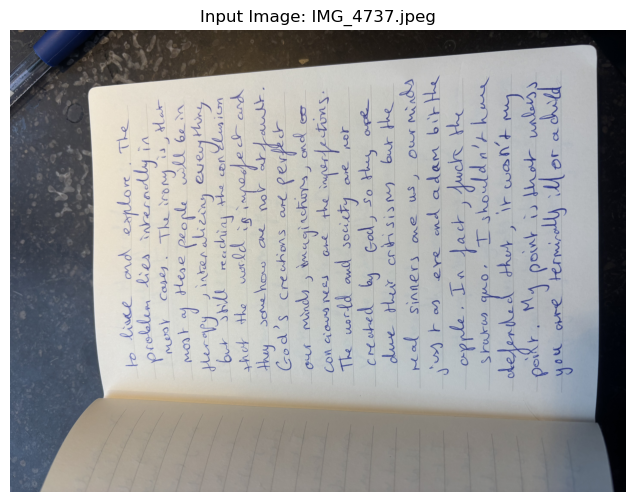

Image size: (5712, 4284)
Image mode: RGB


In [23]:
# Display the image
if image_path.exists():
    img = Image.open(image_path)
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.title(f"Input Image: {image_path.name}")
    plt.axis('off')
    plt.show()
    
    print(f"Image size: {img.size}")
    print(f"Image mode: {img.mode}")

In [24]:
# Load the GOT-OCR-2.0-hf model (HuggingFace Transformers version)
# This version properly supports MPS/CPU unlike the original
from transformers import AutoProcessor, AutoModelForImageTextToText
import torch

# Determine device - MPS for Apple Silicon, CUDA for NVIDIA, else CPU
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

## 3. olmOCR-2 

olmOCR from Allen AI is another powerful document OCR model, fine-tuned from Qwen2-VL. It's designed for high-quality document understanding and text extraction.

In [ ]:
# Load olmOCR-2 model
from transformers import AutoProcessor, AutoModelForImageTextToText
import torch

print("Loading olmOCR-2 model...")

OLMOCR_MODEL = "allenai/olmOCR-2-7B-1025"

# Both processor and model from the same repo
processor_olm = AutoProcessor.from_pretrained(OLMOCR_MODEL)
model_olm = AutoModelForImageTextToText.from_pretrained(
    OLMOCR_MODEL, 
    torch_dtype=torch.bfloat16,
    device_map=device
)

print(f"✓ olmOCR-2 loaded on {device}!")

Loading olmOCR-2 model...


Loading weights:   0%|          | 0/729 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [36]:
# # Check if MLX is available
# try:
#     import mlx.core as mx
#     print(f"✓ MLX is installed!")
#     print(f"  MLX version: {mx.__version__ if hasattr(mx, '__version__') else 'unknown'}")
#     print(f"  Default device: {mx.default_device()}")
#     mlx_available = True
# except ImportError:
#     print("✗ MLX not installed")
#     print("\nTo install MLX, run:")
#     print("  pip install mlx mlx-vlm")
#     mlx_available = False

In [16]:
# Run OCR with olmOCR-2 — with image resolution capped to avoid MPS buffer overflow
# The 124 GiB buffer error happens because Qwen2.5-VL processes images at native resolution,
# creating an enormous attention matrix. Capping max_pixels fixes this.

print(f"Processing image: {image_path}")
print("-" * 50)

# Check original image size
img_check = Image.open(image_path)
orig_w, orig_h = img_check.size
orig_pixels = orig_w * orig_h
print(f"Original image: {orig_w}x{orig_h} = {orig_pixels:,} pixels ({orig_pixels/1e6:.1f} MP)")

# Cap the image resolution to avoid MPS buffer overflow
# 1024*1024 (~1MP) is safe for 48GB; increase to 2048*2048 (~4MP) if you want more detail
MAX_PIXELS = 1024 * 1024  # ~1 megapixel — safe for 48GB MPS
MIN_PIXELS = 256 * 256

print(f"Capping to max_pixels={MAX_PIXELS:,} ({MAX_PIXELS/1e6:.1f} MP)")

# Rebuild processor with pixel limits
processor_olm_capped = AutoProcessor.from_pretrained(
    OLMOCR_MODEL,
    min_pixels=MIN_PIXELS,
    max_pixels=MAX_PIXELS,
)

# Build messages with local image
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "url": str(image_path)},
            {"type": "text", "text": "Extract and return all the text from this handwritten document."}
        ]
    },
]

# Process with capped processor
inputs = processor_olm_capped.apply_chat_template(
    messages,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt",
).to(device)

# Show the actual tensor shapes to verify reduced size
if "pixel_values" in inputs:
    print(f"pixel_values shape: {inputs['pixel_values'].shape}")
if "image_grid_thw" in inputs:
    print(f"image_grid_thw: {inputs['image_grid_thw']}")

print("\nGenerating text...")

# Generate
with torch.no_grad():
    output = model_olm.generate(**inputs, max_new_tokens=2048)

# Decode
result_olm = processor_olm_capped.decode(output[0][inputs["input_ids"].shape[-1]:], skip_special_tokens=True)

print("\n" + "=" * 50)
print("olmOCR-2 RESULT:")
print("=" * 50)
print(result_olm)
print("=" * 50)

Processing image: /Users/marwanbounassif/Documents/repos/handwritten-ocr/data/input/IMG_4737.jpeg
--------------------------------------------------
Original image: 5712x4284 = 24,470,208 pixels (24.5 MP)
Capping to max_pixels=1,048,576 (1.0 MP)
pixel_values shape: torch.Size([5208, 1176])
image_grid_thw: tensor([[ 1, 84, 62]], device='mps:0')

Generating text...
pixel_values shape: torch.Size([5208, 1176])
image_grid_thw: tensor([[ 1, 84, 62]], device='mps:0')

Generating text...

olmOCR-2 RESULT:
to live and explore. The problem lies internally in most cases. The irony is, that most of these people will be in therapy, internalizing everything but still reaching the conclusion that the world is imperfect and they somehow are not at fault. God's creations are perfect our minds, imaginations, and consciousness are the imperfections. The world and society are not created by God, so they are due their criticisms but the real sinners are us, our minds just as eve and adam bit the apple. In

## 🧹 Free OCR Model Memory

Unload all OCR models before running the LLM post-processing step. This frees ~15+ GB of VRAM so Ollama has room to work.

In [30]:
import gc
import torch

# Delete OCR models to free memory
for var_name in ['model_got', 'processor_got', 'model_olm', 'processor_olm', 
                 'processor_olm_capped', 'inputs', 'output', 'generate_ids']:
    if var_name in dir():
        exec(f'del {var_name}')

# Force garbage collection and clear MPS cache
gc.collect()
if torch.backends.mps.is_available():
    torch.mps.empty_cache()

print("✓ OCR models unloaded and memory freed")

✓ OCR models unloaded and memory freed


## 📄 Save OCR Results

Save the transcribed text to organized .txt and .md files in the output directory.

In [ ]:
from datetime import datetime

def save_ocr_result(text: str, source_image: Path, output_dir: Path, formats: list = ["txt", "md"]):
    """
    Save OCR result to organized text and/or markdown files.
    
    Args:
        text: The transcribed text
        source_image: Path to the source image
        output_dir: Directory to save output files
        formats: List of formats to save ("txt", "md", or both)
    
    Returns:
        Dictionary of saved file paths
    """
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Create base filename from source image
    base_name = source_image.stem
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    saved_files = {}
    
    if "txt" in formats:
        # Save as plain text
        txt_path = output_dir / f"{base_name}.txt"
        with open(txt_path, "w", encoding="utf-8") as f:
            f.write(text)
        saved_files["txt"] = txt_path
        print(f"✓ Saved: {txt_path}")
    
    if "md" in formats:
        # Save as markdown with metadata
        md_path = output_dir / f"{base_name}.md"
        md_content = f"""# OCR Transcription: {source_image.name}

**Source:** `{source_image.name}`  
**Processed:** {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}  
**Model:** GOT-OCR-2.0-hf

---

## Transcribed Text

{text}

---

*Generated by Handwritten OCR Pipeline*
"""
        with open(md_path, "w", encoding="utf-8") as f:
            f.write(md_content)
        saved_files["md"] = md_path
        print(f"✓ Saved: {md_path}")
    
    return saved_files

# Define output directory
output_dir = Path.cwd().parent / "data" / "output"
print(f"Output directory: {output_dir}")

In [ ]:
# Save the current OCR result
saved = save_ocr_result(
    text=result_got,
    source_image=image_path,
    output_dir=output_dir,
    formats=["txt", "md"]
)

print(f"\n📁 Files saved to: {output_dir}")

## 🧠 Post-Process OCR Text with Ollama

Use a local LLM via Ollama to clean up, fix, and structure the raw OCR output.

**Run this AFTER saving OCR results and freeing model memory above.**

| Model | Size | Speed | Quality | Fits in 48GB? |
|-------|------|-------|---------|---------------|
| `llama3.1:8b` (installed) | ~5 GB | Fast | Good | ✅ Easily |
| `qwen2.5:14b` | ~9 GB | Medium | Great | ✅ Yes |
| `gemma3:27b` | ~17 GB | Slower | Excellent | ✅ Yes |
| `qwen2.5:32b` | ~20 GB | Slow | Excellent | ⚠️ Tight |
| Any 70B | ~40 GB | Very slow | Best | ❌ No room |

In [32]:
import subprocess
import json
from pathlib import Path

# ── Configuration ──────────────────────────────────────────────────────
# Change this to try different models (see table above)
OLLAMA_MODEL = "llama3.1:8b"  # Already installed — swap to "qwen2.5:14b" etc.

# ── Load raw OCR text from disk ───────────────────────────────────────
output_dir = Path.cwd().parent / "data" / "output"
ocr_txt_path = output_dir / "IMG_4737.txt"  # Update if using a different image

if not ocr_txt_path.exists():
    raise FileNotFoundError(
        f"No OCR output found at {ocr_txt_path}. "
        "Run the OCR + Save cells above first."
    )

raw_ocr_text = ocr_txt_path.read_text(encoding="utf-8")
print(f"✓ Loaded raw OCR text from: {ocr_txt_path.name}")
print(f"  Length: {len(raw_ocr_text)} characters")
print(f"\n--- Raw OCR Preview (first 500 chars) ---")
print(raw_ocr_text[:500])
print("...")

✓ Loaded raw OCR text from: IMG_4737.txt
  Length: 654 characters

--- Raw OCR Preview (first 500 chars) ---
to live and explore. The problem lies inrerally in most cases. The irony is, that most a y these people will be in Hergy, inter alio ing eve y thing but still reaching the con el usi on that the world is in pe fec and they s one how are not a rfa wu t.  God' s creations are per fed our minds, magni c tory, and oo con cio us nees are the imperfections.  The world and society are nor created by God, so Huy are due their crisis m bur the real sinners a eus, our minds jy ras ere and adam bitH he o p
...


In [33]:
# ── Check Ollama is running & model is available ──────────────────────
result = subprocess.run(["ollama", "list"], capture_output=True, text=True)
if result.returncode != 0:
    raise RuntimeError("Ollama is not running. Start it with: ollama serve")

installed_models = result.stdout
print("Installed Ollama models:")
print(installed_models)

if OLLAMA_MODEL.split(":")[0] not in installed_models:
    print(f"\n⚠️  Model '{OLLAMA_MODEL}' not found. Pulling it now...")
    subprocess.run(["ollama", "pull", OLLAMA_MODEL], check=True)
    print(f"✓ {OLLAMA_MODEL} pulled successfully!")
else:
    print(f"✓ {OLLAMA_MODEL} is available")

Installed Ollama models:
NAME                        ID              SIZE      MODIFIED     
llama3.1:8b                 46e0c10c039e    4.9 GB    2 months ago    
mxbai-embed-large:latest    468836162de7    669 MB    2 months ago    

✓ llama3.1:8b is available


In [35]:
raw_ocr_text

"to live and explore. The problem lies inrerally in most cases. The irony is, that most a y these people will be in Hergy, inter alio ing eve y thing but still reaching the con el usi on that the world is in pe fec and they s one how are not a rfa wu t.  God' s creations are per fed our minds, magni c tory, and oo con cio us nees are the imperfections.  The world and society are nor created by God, so Huy are due their crisis m bur the real sinners a eus, our minds jy ras ere and adam bitH he o pple. In fact, f uch the stra vau o, I should n' t hau e defended that, ir won' t my point. My point is that un l by s you are her miro ll y il for a child"

In [ ]:
# ── Send OCR text to Ollama for post-processing ──────────────────────
import requests

SYSTEM_PROMPT = """You are a precise text restoration assistant. You receive raw OCR output 
from handwritten notes. Your job is to:

1. Fix obvious OCR misreadings and garbled characters
2. Restore proper spelling, punctuation, and capitalization
3. Preserve the original structure (headings, lists, paragraphs)
4. Keep the author's original wording — do NOT rephrase or summarize
5. If something is genuinely illegible, mark it as [illegible]

Return ONLY the cleaned text. No commentary, no explanations."""

USER_PROMPT = f"""Clean up the following raw OCR text from a handwritten document. 
Return only the corrected text, preserving the original structure:

---
{raw_ocr_text}
---"""

print(f"Sending to {OLLAMA_MODEL}...")
print(f"Input length: {len(raw_ocr_textaa)} chars")
print("-" * 50)

# Call Ollama API
response = requests.post(
    "http://localhost:11434/api/chat",
    json={
        "model": OLLAMA_MODEL,
        "messages": [
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user", "content": USER_PROMPT},
        ],
        "stream": False,
        "options": {
            "temperature": 0.1,  # Low temp for faithful reproduction
            "num_ctx": 4096,     # Context window
        }
    },
    timeout=300,  # 5 min timeout for large texts
)
response.raise_for_status()

cleaned_text = response.json()["message"]["content"]

print("\n" + "=" * 50)
print(f"CLEANED TEXT ({OLLAMA_MODEL}):")
print("=" * 50)
print(cleaned_text)
print("=" * 50)
print(f"\nOutput length: {len(cleaned_text)} chars")

Sending to llama3.1:8b...
Input length: 654 chars
--------------------------------------------------

CLEANED TEXT (llama3.1:8b):
to live and explore. The problem lies internally in most cases. The irony is, that most of these people will be in Hergy, interfering with everything but still reaching the conclusion that the world is in peace and they see how others are not aware of it.

God's creations are perfect, magnificent, and our conscious needs are the imperfections.  The world and society are not created by God, so humans are due their crisis because the real sinners are us, our minds are jaded and Adam bitH he people. In fact, such is the straw man argument, I shouldn't have defended that, it won't make my point. My point is that unless you are here miraculously ill for a child

Output length: 664 chars


In [ ]:
# ── Save the cleaned text ─────────────────────────────────────────────
from datetime import datetime

output_dir = Path.cwd().parent / "data" / "output"
base_name = ocr_txt_path.stem  # e.g. "IMG_4737"

# Save cleaned .txt
cleaned_txt_path = output_dir / f"{base_name}_cleaned.txt"
cleaned_txt_path.write_text(cleaned_text, encoding="utf-8")
print(f"✓ Saved: {cleaned_txt_path}")

# Save cleaned .md with metadata
cleaned_md_path = output_dir / f"{base_name}_cleaned.md"
md_content = f"""# OCR Transcription (Cleaned): {base_name}

**Source:** `{base_name}.jpeg`  
**OCR Model:** GOT-OCR-2.0-hf  
**Post-processed by:** {OLLAMA_MODEL} (Ollama, local)  
**Processed:** {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}

---

## Transcribed Text

{cleaned_text}

---

*Generated by Handwritten OCR Pipeline → cleaned by {OLLAMA_MODEL}*
"""
cleaned_md_path.write_text(md_content, encoding="utf-8")
print(f"✓ Saved: {cleaned_md_path}")

print(f"\n📁 Cleaned files saved to: {output_dir}")